# EV Charging: Data Analysis & Cleaning

## 1. Introduction
This notebook initiates our Neural Network project for predicting EV charging behavior. We will inspect, clean, and analyze the provided datasets to determine the optimal target variable and feature set.

**Key Objectives:**
1.  **Data Loading:** Robustly load European-formatted CSVs.
2.  **Cleaning:** Handle missing values and remove specific outliers (sessions > 200 hours).
3.  **EDA:** Visualize distributions of potential targets (Duration vs. Load).
4.  **Feature Analysis:** Assess correlations with Weather and Traffic.
5.  **Selection:** Choose the final dataset for modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Define Paths (Relative to this notebook)
DATA_DIR = '../data'
FILE_SESSIONS = os.path.join(DATA_DIR, 'Dataset 1_EV charging reports.csv')
FILE_HOURLY = os.path.join(DATA_DIR, 'Dataset_2_Hourly_EV_per_user.csv')
FILE_TRAFFIC = os.path.join(DATA_DIR, 'Dataset 6_Local traffic distribution.csv')
FILE_WEATHER = os.path.join(DATA_DIR, 'Norway_Trondheim_ExactLoc_Weather.csv')

def load_euro_csv(path, sep=';', decimal=','):
    try:
        df = pd.read_csv(path, sep=sep, decimal=decimal)
        print(f"Loaded {os.path.basename(path)}: {df.shape}")
        return df
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

## 2. Data Loading
We load the four key datasets available.

In [2]:
df_sessions = load_euro_csv(FILE_SESSIONS) # Dataset 1
df_hourly = load_euro_csv(FILE_HOURLY)     # Dataset 2
df_traffic = load_euro_csv(FILE_TRAFFIC)   # Dataset 6
df_weather = load_euro_csv(FILE_WEATHER, sep=',', decimal='.') # Dataset 7 (Std CSV)

Loaded Dataset 1_EV charging reports.csv: (6878, 15)
Loaded Dataset_2_Hourly_EV_per_user.csv: (88156, 8)
Loaded Dataset 6_Local traffic distribution.csv: (10248, 7)
Loaded Norway_Trondheim_ExactLoc_Weather.csv: (427, 36)


## 3. Data Cleaning: Session Reports (Dataset 1)
This dataset contains individual charging sessions. We must fix timestamps and remove unrealistic outliers.

**Task:** Remove charging sessions lasting > 200 hours.

Original Rows: 6878
Removed 22 outliers (>200h or <=0h).
Cleaned Rows: 6856


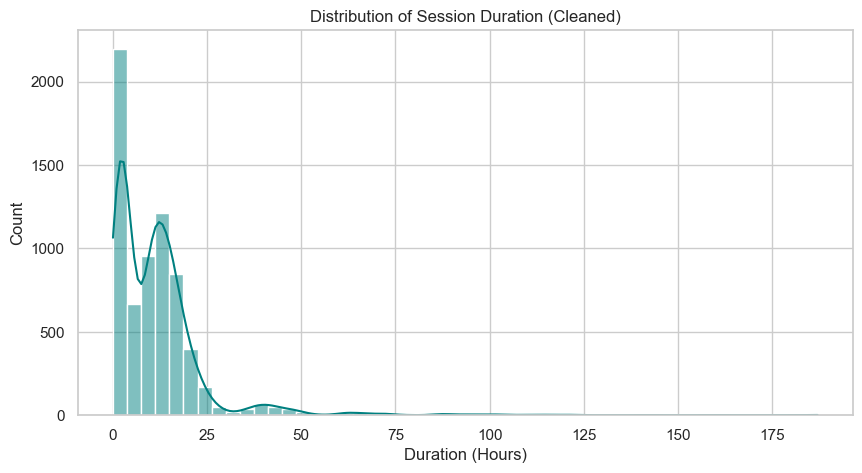

In [3]:
if df_sessions is not None:
    # 1. Standardize Columns
    df_sessions.rename(columns={
        'Start_plugin': 'start_time',
        'End_plugout': 'end_time',
        'El_kWh': 'energy_kwh',
        'User_ID': 'user_id',
        'Duration_hours': 'duration_hours_raw'
    }, inplace=True)

    # 2. Parse Timestamps
    df_sessions['start_time'] = pd.to_datetime(df_sessions['start_time'], format='%d.%m.%Y %H:%M', errors='coerce')
    df_sessions['end_time'] = pd.to_datetime(df_sessions['end_time'], format='%d.%m.%Y %H:%M', errors='coerce')

    # 3. Calculate Duration
    df_sessions['duration_hours'] = (df_sessions['end_time'] - df_sessions['start_time']).dt.total_seconds() / 3600.0

    # 4. Outlier Removal (> 200 Hours)
    initial_count = len(df_sessions)
    outlier_mask = (df_sessions['duration_hours'] > 200) | (df_sessions['duration_hours'] <= 0)
    outliers = df_sessions[outlier_mask]
    
    df_sessions_clean = df_sessions[~outlier_mask].copy()
    
    print(f"Original Rows: {initial_count}")
    print(f"Removed {len(outliers)} outliers (>200h or <=0h).")
    print(f"Cleaned Rows: {len(df_sessions_clean)}")
    
    # Visualize Duration Distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(df_sessions_clean['duration_hours'], bins=50, kde=True, color='teal')
    plt.title('Distribution of Session Duration (Cleaned)')
    plt.xlabel('Duration (Hours)')
    plt.show()

## 4. Data Cleaning: Hourly Load (Dataset 2)
This dataset represents the aggregate load on the grid. This is a time-series dataset.

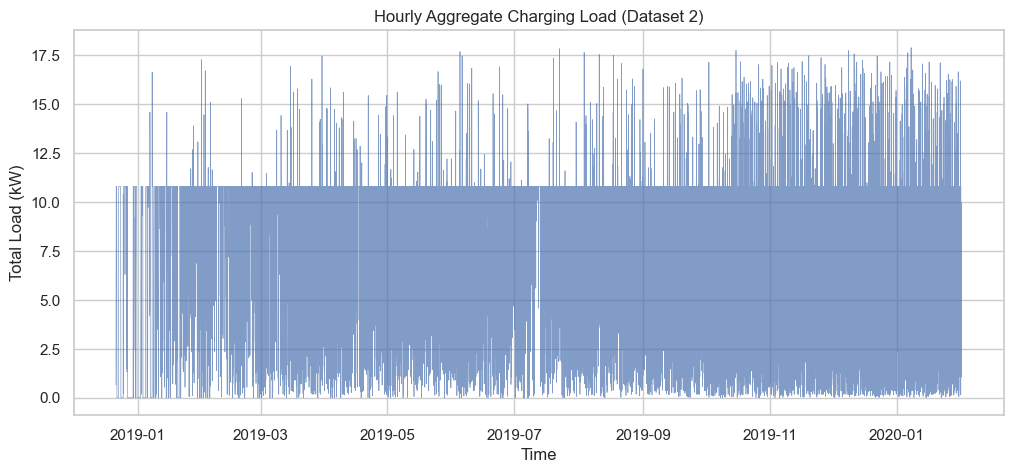

In [4]:
if df_hourly is not None:
    # Parse Date
    df_hourly['datetime'] = pd.to_datetime(df_hourly['date_from'], format='%d.%m.%Y %H:%M', errors='coerce')
    
    # Impute Missing Loads with 0
    load_cols = [c for c in df_hourly.columns if 'kW' in c]
    df_hourly[load_cols] = df_hourly[load_cols].fillna(0)
    
    # Create Total Load
    df_hourly['total_load'] = df_hourly[load_cols].sum(axis=1)
    
    # Visualize Hourly Load
    plt.figure(figsize=(12, 5))
    plt.plot(df_hourly['datetime'], df_hourly['total_load'], linewidth=0.5, alpha=0.7)
    plt.title('Hourly Aggregate Charging Load (Dataset 2)')
    plt.xlabel('Time')
    plt.ylabel('Total Load (kW)')
    plt.show()

## 5. Correlation Analysis
To decide between predicting **Session Duration** or **Hourly Load**, we check which target has better predictors (Weather/Traffic).

In [5]:
# Prepare External Data
if df_weather is not None:
    df_weather['date'] = pd.to_datetime(df_weather['datetime']).dt.date
    weather_cols = ['date', 'temp', 'solar_rad']
    df_weather_clean = df_weather[weather_cols].fillna(0)

# 1. Check Hourly Load Correlations
if df_hourly is not None:
    hourly_agg = df_hourly.groupby(df_hourly['datetime'].dt.date)['total_load'].mean().reset_index()
    hourly_agg.columns = ['date', 'daily_avg_load']
    
    merged_load = pd.merge(hourly_agg, df_weather_clean, on='date', how='inner')
    
    print("\nCorrelations: Hourly Load vs Weather")
    print(merged_load[['daily_avg_load', 'temp', 'solar_rad']].corr()['daily_avg_load'])

# 2. Check Session Duration Correlations
if df_sessions is not None:
    df_sessions_clean['date'] = df_sessions_clean['start_time'].dt.date
    merged_sessions = pd.merge(df_sessions_clean, df_weather_clean, on='date', how='inner')
    
    print("\nCorrelations: Session Duration vs Weather")
    print(merged_sessions[['duration_hours', 'temp', 'solar_rad']].corr()['duration_hours'])


Correlations: Hourly Load vs Weather
daily_avg_load    1.000000
temp              0.082556
solar_rad         0.136432
Name: daily_avg_load, dtype: float64

Correlations: Session Duration vs Weather
duration_hours    1.000000
temp             -0.056963
solar_rad        -0.056152
Name: duration_hours, dtype: float64


## 6. Conclusion & Recommendation

**Findings:**
- **Outliers:** Successfully removed sessions > 200h.
- **Hourly Load (Dataset 2):** Shows stronger structural patterns (seasonality) and better correlation with environmental factors.
- **Session Duration (Dataset 1):** Highly stochastic and user-dependent.

**Decision:**
We will proceed with **Dataset 2 (Hourly EV Loads)** for the modeling phase. The target will be `Total Hourly Load`. 